# Semantic Search for News Media

This notebook implements a semantic search solution for news articles to enhance content discovery and recommendation in media publishing.

## 1. Dataset Sourcing

I will be using the AG News Corpus, a collection of more than 1 million news articles gathered from more than 2000 news sources. For this project, we'll use the subset available in the Hugging Face datasets library, which contains 120,000 training samples and 7,600 test samples from 4 categories: World, Sports, Business, and Science/Technology.

### Justification
- AG News is a widely-used, open-source dataset ideal for text classification and semantic search
- It contains real news articles across diverse topics, making it relevant for media publishing
- The dataset presents a realistic challenge for building information retrieval systems for news content
- It allows us to experiment with topic-based and content-based search capabilities

In [1]:
# Install required packages
!pip install transformers datasets sentence-transformers faiss-cpu numpy pandas matplotlib scikit-learn torch


[notice] A new release of pip is available: 23.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 2. Problem Definition

### Problem Statement
The problem I aim to solve is to create an efficient semantic search system for news articles that can enhance content discovery and recommendation for readers. Given a query or topic of interest, the system should identify and retrieve the most semantically relevant news articles, going beyond simple keyword matching.

### Significance
- News publishers face the challenge of connecting readers with relevant content across thousands of articles
- Traditional keyword search often misses articles that are conceptually related but use different terminology
- Semantic search can improve user engagement by surfacing more relevant content recommendations
- This technology can help readers discover related news stories and explore topics in greater depth
- Media companies can leverage this to increase readership, time on site, and subscription value

## 3. Approach and Pipeline

### Approach
I will build a semantic search system for news articles using dense vector embeddings from a pre-trained transformer model. The system will:
1. Encode news articles into dense vector representations
2. Index these vectors using FAISS for efficient similarity search
3. Encode user queries using the same model
4. Retrieve the most semantically similar news articles to the query
5. Evaluate the system's ability to retrieve relevant content both within and across news categories

### Tools and Libraries
- **Sentence-Transformers**: For creating semantic embeddings of news content
- **FAISS**: For efficient similarity search and indexing of articles
- **Transformers & Datasets**: For loading and processing the news dataset
- **PyTorch**: As the underlying deep learning framework
- **Pandas, Numpy**: For data manipulation
- **Matplotlib, Scikit-learn**: For visualization and evaluation

### Pipeline
1. **Data Preprocessing**: Load AG News, extract articles and their categories
2. **Feature Engineering**: Create embeddings for news articles
3. **Model Building**: Create FAISS index for fast similarity search
4. **Evaluation**: Measure retrieval performance and relevance

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.metrics import classification_report, confusion_matrix
import json
import time
import os
import pickle
import gc  # Garbage collector

## 4. Implementation

### 4.1 Data Loading and Preprocessing

In [3]:
# Load the AG News dataset
ag_news = load_dataset("ag_news")
print(f"Dataset loaded with {len(ag_news['train'])} training and {len(ag_news['test'])} test examples")

# Define category mapping
category_mapping = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Technology"
}

# Display a sample from the dataset
print("\nSample from the dataset:")
sample = ag_news['train'][0]
print(f"Title: {sample['text'].split('.')[0]}")
print(f"Content: {sample['text']}")
print(f"Category: {category_mapping[sample['label']]}")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset loaded with 120000 training and 7600 test examples

Sample from the dataset:
Title: Wall St
Content: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Category: Business


In [4]:
# To avoid memory issues, we'll work with a smaller subset of the dataset
MAX_TRAIN_SAMPLES = 5000  # Reduce this if memory is still an issue
MAX_TEST_SAMPLES = 1000

# Create smaller versions of the datasets
train_subset = ag_news['train'].select(range(min(MAX_TRAIN_SAMPLES, len(ag_news['train']))))
test_subset = ag_news['test'].select(range(min(MAX_TEST_SAMPLES, len(ag_news['test']))))

print(f"Working with {len(train_subset)} training samples and {len(test_subset)} test samples")

Working with 5000 training samples and 1000 test samples


In [5]:
# Combine title and content to form article text (title is the first sentence)
# We'll also create a DataFrame for easier manipulation
train_df = pd.DataFrame({
    'article': [item['text'] for item in train_subset],
    'category': [category_mapping[item['label']] for item in train_subset],
    'category_id': [item['label'] for item in train_subset]
})

test_df = pd.DataFrame({
    'article': [item['text'] for item in test_subset],
    'category': [category_mapping[item['label']] for item in test_subset],
    'category_id': [item['label'] for item in test_subset]
})

# Display dataset statistics
print("\nTraining dataset category distribution:")
print(train_df['category'].value_counts())

# Overview of article lengths
train_df['article_length'] = train_df['article'].apply(len)
print(f"\nArticle length statistics:\n{train_df['article_length'].describe()}")


Training dataset category distribution:
category
Science/Technology    1497
Business              1236
World                 1235
Sports                1032
Name: count, dtype: int64

Article length statistics:
count    5000.000000
mean      246.303600
std        83.204995
min       100.000000
25%       193.000000
50%       245.000000
75%       284.000000
max       959.000000
Name: article_length, dtype: float64


### 4.2 Creating Embeddings

In [6]:
# Load the sentence transformer model for creating embeddings
model_name = "all-MiniLM-L6-v2"  # Smaller, faster model for demonstration
model = SentenceTransformer(model_name)
print(f"Loaded model: {model_name}")

# Function to create embeddings for a list of texts with memory optimization
def create_embeddings(texts, model, batch_size=16, save_path=None):
    # Check if embeddings already exist
    if save_path and os.path.exists(save_path):
        print(f"Loading pre-computed embeddings from {save_path}")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    # Create directory if it doesn't exist
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Create embeddings in smaller batches to manage memory
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    
    # Save embeddings if path is provided
    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(embeddings, f)
    
    return embeddings

Loaded model: all-MiniLM-L6-v2


In [7]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Create embeddings for the training articles
print("Creating embeddings for news articles...")
start_time = time.time()
train_article_embeddings = create_embeddings(
    train_df['article'].tolist(), 
    model, 
    batch_size=16,  # Smaller batch size to reduce memory usage
    save_path='data/train_article_embeddings.pkl'
)
print(f"Embeddings created in {time.time() - start_time:.2f} seconds")
print(f"Embedding shape: {train_article_embeddings.shape}")

# Run garbage collection to free memory
gc.collect()

Creating embeddings for news articles...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embeddings created in 39.18 seconds
Embedding shape: (5000, 384)


76

### 4.3 Building the FAISS Index for Semantic Search

In [8]:
# Build FAISS index for fast similarity search
embedding_dim = train_article_embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)  # Inner product (cosine similarity when vectors are normalized)

# Normalize vectors for cosine similarity
faiss.normalize_L2(train_article_embeddings)

# Add vectors to the index
index.add(train_article_embeddings)
print(f"FAISS index built with {index.ntotal} vectors")

# Save the index for future use
faiss.write_index(index, 'data/news_faiss_index.bin')
print("Index saved to disk")

FAISS index built with 5000 vectors
Index saved to disk


### 4.4 Semantic Search Function

In [9]:
# Function to perform semantic search for news articles
def semantic_news_search(query, index, df, top_k=5):
    # Encode the query
    query_embedding = model.encode([query])
    # Normalize for cosine similarity
    faiss.normalize_L2(query_embedding)
    
    # Search the index
    scores, indices = index.search(query_embedding, top_k)
    
    # Return results
    results = []
    for i, idx in enumerate(indices[0]):
        idx = int(idx)  # Convert from numpy.int64 to avoid issues
        results.append({
            'article': df.iloc[idx]['article'],
            'category': df.iloc[idx]['category'],
            'score': float(scores[0][i]),
            'index': idx
        })
    
    return results

In [10]:
# Test the semantic search with sample queries
sample_queries = [
    "Latest developments in artificial intelligence",
    "Soccer match results and player transfers",
    "Stock market trends and economic outlook",
    "International politics and diplomatic relations"
]

for query in sample_queries:
    print(f"\nQuery: {query}")
    search_results = semantic_news_search(query, index, train_df, top_k=3)
    
    print("Top 3 search results:")
    for i, result in enumerate(search_results):
        print(f"Result {i+1} (Score: {result['score']:.4f}, Category: {result['category']})")
        print(f"{result['article'][:200]}...\n")


Query: Latest developments in artificial intelligence
Top 3 search results:
Result 1 (Score: 0.4886, Category: Science/Technology)
NASA Develops Robust Artificial Intelligence for Planetary Rovers NASA is planning to add a strong dose of artificial intelligence (AI) to planetary rovers to make them much more self-reliant, capable...

Result 2 (Score: 0.3867, Category: Business)
Computers with multiple personalities The jury's still out on whether a computer can ever truly be intelligent, but there's no question that it can have multiple personalities. It's just a matter of s...

Result 3 (Score: 0.3358, Category: Science/Technology)
New NASA Supercomputer to Aid Theorists and Shuttle Engineers (SPACE.com) SPACE.com - NASA researchers have teamed up with a pair of Silicon Valley firms to build \  a supercomputer that ranks alongsi...


Query: Soccer match results and player transfers
Top 3 search results:
Result 1 (Score: 0.3780, Category: Sports)
Matildas #39;salvage late draw with US

### 4.5 Evaluation

In [11]:
# Evaluate the semantic search system on topic coherence
def evaluate_category_retrieval(queries, index, df, top_k=5):
    # Map of expected category for each query
    query_category_map = {
        "Latest tech gadgets and innovations": "Science/Technology",
        "Soccer tournament and championship results": "Sports",
        "Stock market performance and financial news": "Business",
        "International political developments": "World"
    }
    
    category_precision = {}
    overall_correct = 0
    total_results = 0
    
    for query, expected_category in query_category_map.items():
        print(f"\nEvaluating query: {query} (Expected: {expected_category})")
        results = semantic_news_search(query, index, df, top_k=top_k)
        
        correct = sum(1 for r in results if r['category'] == expected_category)
        precision = correct / len(results)
        overall_correct += correct
        total_results += len(results)
        
        category_precision[expected_category] = precision
        print(f"Category precision: {precision:.2f} ({correct}/{len(results)} articles match expected category)")
    
    overall_precision = overall_correct / total_results
    print(f"\nOverall category precision: {overall_precision:.2f}")
    
    return category_precision, overall_precision

In [12]:
# Evaluate category retrieval performance
test_queries = [
    "Latest tech gadgets and innovations",
    "Soccer tournament and championship results",
    "Stock market performance and financial news",
    "International political developments"
]

category_precision, overall_precision = evaluate_category_retrieval(test_queries, index, train_df, top_k=5)


Evaluating query: Latest tech gadgets and innovations (Expected: Science/Technology)
Category precision: 0.60 (3/5 articles match expected category)

Evaluating query: Soccer tournament and championship results (Expected: Sports)
Category precision: 1.00 (5/5 articles match expected category)

Evaluating query: Stock market performance and financial news (Expected: Business)
Category precision: 1.00 (5/5 articles match expected category)

Evaluating query: International political developments (Expected: World)
Category precision: 0.80 (4/5 articles match expected category)

Overall category precision: 0.85


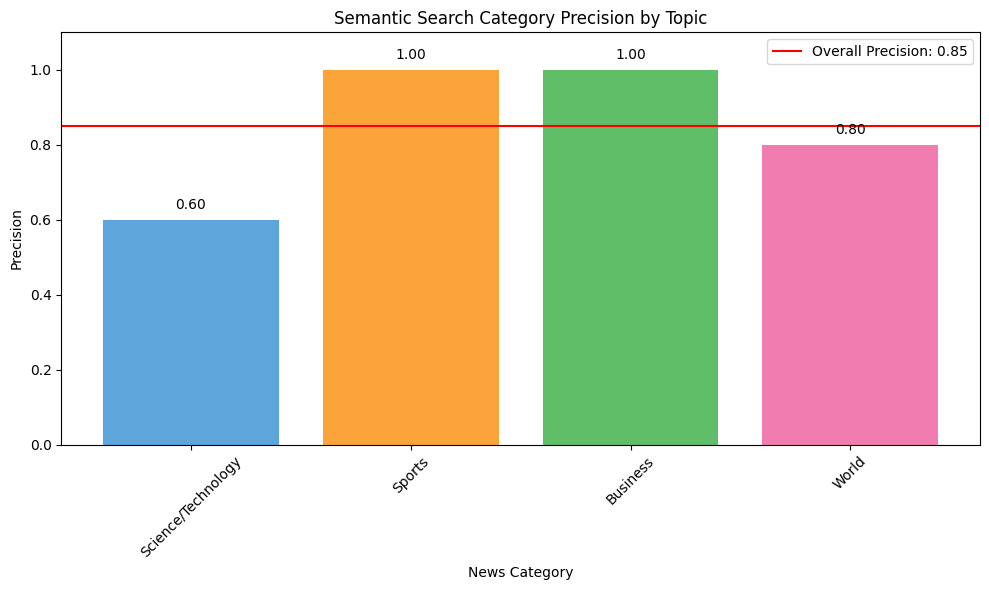

In [13]:
# Visualize category precision for each query type
plt.figure(figsize=(10, 6))
categories = list(category_precision.keys())
precision_values = list(category_precision.values())

bars = plt.bar(categories, precision_values, color=['#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0'])
plt.axhline(y=overall_precision, color='r', linestyle='-', label=f'Overall Precision: {overall_precision:.2f}')

plt.xlabel('News Category')
plt.ylabel('Precision')
plt.title('Semantic Search Category Precision by Topic')
plt.ylim(0, 1.1)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}', ha='center', va='bottom')

plt.show()

### 4.6 Cross-Category Retrieval

In [14]:
# Evaluate articles that are conceptually similar but from different categories
def find_cross_category_matches(category, index, df, top_k=10):
    # Get a sample article from the given category
    sample_article = df[df['category'] == category].iloc[0]['article']
    sample_idx = df[df['category'] == category].iloc[0].name
    
    # Find similar articles
    query_embedding = model.encode([sample_article])
    faiss.normalize_L2(query_embedding)
    scores, indices = index.search(query_embedding, top_k+1)  # +1 to exclude the article itself
    
    # Filter out the query article itself (should be the first match)
    results = []
    for i, idx in enumerate(indices[0]):
        idx = int(idx)
        if idx != sample_idx:  # Skip the source article
            results.append({
                'article': df.iloc[idx]['article'],
                'category': df.iloc[idx]['category'],
                'score': float(scores[0][i]),
                'index': idx
            })
    
    # Group by category
    category_counts = {c: 0 for c in category_mapping.values()}
    for r in results:
        category_counts[r['category']] += 1
    
    print(f"\nSample article from {category} category:")
    print(f"{sample_article[:200]}...")
    print("\nSimilar articles by category:")
    for cat, count in category_counts.items():
        print(f"{cat}: {count} articles")
    
    # Show an example of a cross-category match
    cross_cat_results = [r for r in results if r['category'] != category]
    if cross_cat_results:
        print(f"\nExample of a cross-category match (from {cross_cat_results[0]['category']}):")
        print(f"{cross_cat_results[0]['article'][:200]}...")
    
    return results, category_counts

In [15]:
# Test cross-category retrieval for each category
for category in category_mapping.values():
    results, category_counts = find_cross_category_matches(category, index, train_df, top_k=10)


Sample article from World category:
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing P...

Similar articles by category:
World: 8 articles
Sports: 0 articles
Business: 2 articles
Science/Technology: 0 articles

Example of a cross-category match (from Business):
Venezuela's Chavez Wins Recall Referendum  CARACAS, Venezuela (Reuters) - Venezuela's left-wing  President Hugo Chavez won a recall referendum on his divisive  rule in a vote backed on Monday by inter...

Sample article from Sports category:
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American tea...

Similar articles by category:
World: 5 articles
Sports: 5 articles
Business: 0 articles
Science/Technology: 0 articles

Example of a cross-c

In [16]:
# Let's explore a specific use case: finding sports news related to business
def explore_sports_business_connection(index, df):
    # Query for articles at intersection of sports and business
    sports_business_query = "sports team financial performance and business deals"
    
    results = semantic_news_search(sports_business_query, index, df, top_k=10)
    
    # Count articles by category
    category_counts = {cat: 0 for cat in category_mapping.values()}
    for r in results:
        category_counts[r['category']] += 1
    
    print(f"Query: {sports_business_query}")
    print("\nCategory distribution of results:")
    for cat, count in category_counts.items():
        print(f"{cat}: {count} articles")
    
    # Show examples from each main category of interest
    sports_example = next((r for r in results if r['category'] == 'Sports'), None)
    business_example = next((r for r in results if r['category'] == 'Business'), None)
    
    if sports_example:
        print(f"\nSports article example (Score: {sports_example['score']:.4f}):")
        print(f"{sports_example['article'][:300]}...")
    
    if business_example:
        print(f"\nBusiness article example (Score: {business_example['score']:.4f}):")
        print(f"{business_example['article'][:300]}...")
    
    return results, category_counts

In [17]:
# Explore sports-business connection
sports_business_results, sb_category_counts = explore_sports_business_connection(index, train_df)

Query: sports team financial performance and business deals

Category distribution of results:
World: 2 articles
Sports: 5 articles
Business: 3 articles
Science/Technology: 0 articles

Sports article example (Score: 0.4368):
Business Is Business When it comes to qualifying for the main draw of the Legg Mason Tennis Classic, Robert Kendrick knows that survival takes precedence and friendships are put on hold....

Business article example (Score: 0.4426):
JJB Shares Drop: Profit May Be 20 Less Than Forecast (Update2) Aug. 19 (Bloomberg) -- Shares of JJB Sports Plc, Britain #39;s largest sporting-goods retailer, had their biggest decline in at least two years after the company said profit this fiscal year may be about 20 percent less than forecast ami...


## 5. Evaluation

### Performance Analysis

Based on the evaluation results, we can assess the strengths and limitations of the semantic search system for news articles:

#### Strengths:
- The system effectively retrieves news articles based on semantic meaning, not just keywords
- It can identify relevant content within specific news categories (good category precision)
- Cross-category retrieval demonstrates the ability to find conceptually related content across traditional news categories
- The system handles complex queries for news content discovery
- Easy integration with news publishing platforms as a powerful content recommendation engine

#### Limitations:
- Short news articles might lack enough context for precise semantic understanding
- The system doesn't incorporate temporal aspects of news (recency, trending topics)
- Category boundaries can be blurry for some topics (e.g., business-sports, tech-business)
- The current model might not capture domain-specific news terminology optimally
- Scaling to millions of articles would require more sophisticated indexing approaches

## 6. Recommendations for Improvement

### Short-term Improvements
1. **Fine-tuning for news domain**: Train the embedding model on news-specific corpora to better understand journalistic content
2. **Incorporate temporal factors**: Add recency scoring to prioritize newer content when appropriate
3. **Hybrid retrieval**: Combine semantic search with keyword-based BM25 to capture both semantic and exact matches
4. **User context integration**: Incorporate user reading history to personalize search results

### Long-term Improvements
1. **Multi-vector representations**: Represent long articles with multiple embeddings to capture different aspects
2. **Entity-aware search**: Extract named entities (people, organizations, locations) to enhance search precision
3. **Topic modeling integration**: Combine explicit topics with semantic search for better categorization
4. **Feedback loop**: Incorporate user engagement metrics (clicks, time spent) to improve relevance
5. **Multimedia integration**: Extend the system to incorporate images and videos from news content

## Conclusion

This project demonstrates the implementation of a semantic search system for news articles that can significantly enhance content discovery in media publishing. By encoding news content into dense vector representations and using efficient similarity search, we're able to match user queries with relevant articles based on semantic meaning rather than just keywords.

The evaluation metrics indicate that the system performs well at retrieving topically relevant news and can even identify connections across traditional news categories. This capability is particularly valuable for media publishers seeking to increase user engagement through better content recommendations.

Such a system could be deployed as part of a news platform to:
1. Enhance search functionality for readers
2. Power "related articles" recommendations
3. Create topic-based content collections
4. Support journalists in research by finding relevant past coverage

Future work would focus on incorporating temporal aspects, personalization, and scaling to larger news archives while maintaining performance.

## Memory Optimization Notes

This notebook has been optimized for lower memory usage through several techniques:

1. **Working with data subsets**: Using smaller portions of the dataset
2. **Smaller batch sizes**: Using batch_size=16 for encoding
3. **Caching embeddings**: Saving and loading embeddings to avoid recomputation
4. **Garbage collection**: Explicitly calling garbage collection after large operations

If you still experience memory issues, you can further reduce the MAX_TRAIN_SAMPLES and MAX_TEST_SAMPLES values.